In [1]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(scales)
library(broom)
library(repr)
library(stargazer)
library(iterators)
library(forcats)
options(repr.plot.width=10, repr.plot.height=10, digits = 3)
source('~/covid_mobility/paper_code/utils/adjacency_and_cluster_robust_inference.R')
source('~/covid_mobility/paper_code/utils/geo_utils.r')
source("~/covid_mobility/paper_code/utils/labels_and_colors.r")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lmtest’


The following object is masked from ‘package:lfe’:

    waldtest




# Reproducing DID results for comparison

In [2]:
model_save_location = '/nfs/sloanlab004/projects/covid_mobility_proj/models'

In [3]:
# Load focal + geo + social models
DID.mp.aITT.sg_hd <- readRDS(file=str_c(model_save_location, 'did_sgnhd_both.rds'))  
out_hd_aitt_sg <- readRDS(file=str_c(model_save_location, 'did_sgnhd_both_vcov.rds'))
DID.mp.aITT.sg_rstu <- readRDS(file=str_c(model_save_location, 'did_fbnrstu_both.rds'))                                      
out_rstu_aitt_sg <- readRDS(file=str_c(model_save_location, 'did_fbrnstu_both_vcov.rds'))
DID.mp.aITT.sg_cbgv <- readRDS(file=str_c(model_save_location, 'did_sgcbgv_both.rds'))                 
out_cbgv_aitt_sg <- readRDS(file=str_c(model_save_location, 'did_sgcbgv_both_vcov.rds'))
DID.mp.aITT.sg_btvrc <- readRDS(file=str_c(model_save_location, 'did_fbbtvrc_both.rds'))          
out_btvrc_aitt_sg <- readRDS(file=str_c(model_save_location, 'did_fbbtvrc_both_vcov.rds'))



In [4]:
did_models <- list(DID.mp.aITT.sg_hd, DID.mp.aITT.sg_rstu, DID.mp.aITT.sg_cbgv, DID.mp.aITT.sg_btvrc)
did_cts <- list(out_hd_aitt_sg$ct, out_rstu_aitt_sg$ct, out_cbgv_aitt_sg$ct, out_btvrc_aitt_sg$ct)
did_vcovs <- list(out_hd_aitt_sg$vcov.both, out_rstu_aitt_sg$vcov.both, out_cbgv_aitt_sg$vcov.both, out_btvrc_aitt_sg$vcov.both)

did_results <- foreach(m = did_models, i = icount(), .combine = bind_rows) %do% {
    res <- tidy(did_cts[[i]])

    
    res <- res %>% rename(
        coef = estimate,
        se = std.error
        )
    
    comb_alter_sh_wt <- felm.waldtest.mod(
        m,
        as.formula(~ alter_sh.r + geo_alter_sh.r),
        vcov = did_vcovs[[i]]
        ) %>% as.list() %>% as.data.frame() %>%
    select(coef = beta, se, p.value = p) %>%
    mutate(term = 'comb_alter_sh.r')
    
    comb_alter_bgmr_wt <- felm.waldtest.mod(
        m,
        as.formula(~ alter_bgmr.r + geo_alter_bgmr.r),
        vcov = did_vcovs[[i]]
        ) %>% as.list() %>% as.data.frame() %>%
    select(coef = beta, se, p.value = p) %>%
    mutate(term = 'comb_alter_bgmr.r')
    
    res <- bind_rows(res, comb_alter_sh_wt, comb_alter_bgmr_wt)
    
    res$lhs <- m$lhs
    
    res <- res %>%
        mutate(
            ub = coef + 1.96 * se,
            lb = coef - 1.96 * se,
            outcome = outcome_labels[lhs],
            outcome_type = outcome_types[outcome],
            outcome_source = get_outcome_source(as.character(outcome)),
            term_label = term_labels[term]
            )
    
    res
}

In [5]:
did_results

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
stay_home.r,-0.01262,0.00567,-2.227,3.05e-02,asinh_sg_nhd.r,-0.001515,-0.02373,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,Shelter-in-place
alter_sh.r,-0.03982,0.01692,-2.353,2.26e-02,asinh_sg_nhd.r,-0.006655,-0.07298,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,Shelter-in-place (social alters)
geo_alter_sh.r,-0.01079,0.00883,-1.221,2.28e-01,asinh_sg_nhd.r,0.006526,-0.02811,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,Shelter-in-place (geo alters)
ban_gmr.r,-0.00416,0.00287,-1.451,1.53e-01,asinh_sg_nhd.r,0.001460,-0.00977,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,"Close gyms, movie theaters, restaurants"
alter_bgmr.r,0.00886,0.00925,0.958,3.43e-01,asinh_sg_nhd.r,0.026994,-0.00927,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,"Close gyms, movie theaters, restaurants (social alters)"
geo_alter_bgmr.r,-0.01186,0.00652,-1.818,7.50e-02,asinh_sg_nhd.r,0.000923,-0.02464,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,"Close gyms, movie theaters, restaurants (geo alters)"
comb_alter_sh.r,-0.05061,0.00974,NA,2.05e-07,asinh_sg_nhd.r,-0.031514,-0.06970,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,Shelter-in-place (all alters)
comb_alter_bgmr.r,-0.00300,0.00471,NA,5.24e-01,asinh_sg_nhd.r,0.006226,-0.01222,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,"Close gyms, movie theaters, restaurants (all alters)"
stay_home.r,-0.00776,0.00455,-1.704,9.45e-02,asinh_fb_rnstu.r,0.001164,-0.01668,Multi-tile users (FB),Leaving home location,Facebook,Shelter-in-place


# Load and format IV results


In [6]:
model_save_location = '/nfs/sloanlab004/projects/covid_mobility_proj/models/'

In [7]:
# Load IV models
iv_fb_btvrc <- readRDS(file=str_c(model_save_location, 'iv_fb_btvrc_mod_v2.rds'))  
iv_fb_btvrc_tests <- readRDS(file=str_c(model_save_location, 'iv_fb_btvrc_v2.rds'))  
iv_ash_rnstu <- readRDS(file=str_c(model_save_location, 'iv_ash_rnstu_mod_v2.rds'))                                      
iv_ash_rnstu_tests <- readRDS(file=str_c(model_save_location, 'iv_ash_rnstu_v2.rds')) 
iv_ash_nhd <- readRDS(file=str_c(model_save_location, 'iv_ash_nhd_mod_v2.rds'))                 
iv_ash_nhd_tests <- readRDS(file=str_c(model_save_location, 'iv_ash_nhd_v2.rds'))                 
iv_log_mcbgv <- readRDS(file=str_c(model_save_location, 'iv_log_mcbgv_mod_v2.rds'))          
iv_log_mcbgv_tests <- readRDS(file=str_c(model_save_location, 'iv_log_mcbgv_v2.rds'))


In [8]:
iv_models <- list(iv_fb_btvrc, iv_ash_rnstu, iv_ash_nhd, iv_log_mcbgv)
iv_cts <- list(iv_fb_btvrc_tests$ct, iv_ash_rnstu_tests$ct, iv_ash_nhd_tests$ct, iv_log_mcbgv_tests$ct)
iv_vcovs <- list(iv_fb_btvrc_tests$vcov.both, iv_ash_rnstu_tests$vcov.both, iv_ash_nhd_tests$vcov.both, iv_log_mcbgv_tests$vcov.both)


iv_results_all <- foreach(m = iv_models, i = icount(), .combine = bind_rows) %do% {
    res <- tidy(iv_cts[[i]])

    res <- res %>% rename(
        coef = estimate,
        se = std.error
        )
    
    comb_alter_sh_wt <- felm.waldtest.mod(
        m,
        as.formula(~ alter_sh.r + geo_alter_sh.r),
        vcov = iv_vcovs[[i]]
        ) %>% as.list() %>% as.data.frame() %>%
    select(coef = beta, se, p.value = p) %>%
    mutate(term = 'comb_alter_sh.r')
    
    comb_alter_bgmr_wt <- felm.waldtest.mod(
        m,
        as.formula(~ alter_bgmr.r + geo_alter_bgmr.r),
        vcov = iv_vcovs[[i]]
        ) %>% as.list() %>% as.data.frame() %>%
    select(coef = beta, se, p.value = p) %>%
    mutate(term = 'comb_alter_bgmr.r')
    
    res <- bind_rows(res, comb_alter_sh_wt, comb_alter_bgmr_wt)
    
    res$lhs <- m$lhs
    
    res <- res %>%
        mutate(
            ub = coef + 1.96 * se,
            lb = coef - 1.96 * se,
            outcome = outcome_labels[lhs],
            outcome_type = outcome_types[outcome],
            outcome_source = get_outcome_source(as.character(outcome)),
            term_label = term_labels[term]
            )
    
    res
}


In [9]:
head(iv_results_all)

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
shiftshare_11.r,0.0306,1.827,0.0167,9.87e-01,fb_btvrc.r,3.611,-3.5503,Tiles visited per device (FB),Locations visited,Facebook,NA
shiftshare_21.r,3.6093,0.700,5.1546,4.35e-06,fb_btvrc.r,4.982,2.2369,Tiles visited per device (FB),Locations visited,Facebook,NA
shiftshare_22.r,-1.0370,0.325,-3.1882,2.47e-03,fb_btvrc.r,-0.400,-1.6746,Tiles visited per device (FB),Locations visited,Facebook,NA
shiftshare_23.r,2.5363,0.750,3.3812,1.41e-03,fb_btvrc.r,4.006,1.0661,Tiles visited per device (FB),Locations visited,Facebook,NA
shiftshare_31.r,-1.2813,0.318,-4.0238,1.94e-04,fb_btvrc.r,-0.657,-1.9055,Tiles visited per device (FB),Locations visited,Facebook,NA
shiftshare_32.r,5.0900,2.619,1.9437,5.76e-02,fb_btvrc.r,10.223,-0.0427,Tiles visited per device (FB),Locations visited,Facebook,NA


In [10]:
iv_results <- iv_results_all %>% filter(!is.na(term_label))

In [11]:
head(iv_results)

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ban_gmr.r,-0.01125,0.00513,-2.193,0.03296,fb_btvrc.r,-0.0012,-0.02130,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants"
alter_bgmr.r,0.00402,0.01205,0.334,0.73998,fb_btvrc.r,0.0276,-0.01960,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (social alters)"
geo_alter_bgmr.r,0.01114,0.00859,1.297,0.20050,fb_btvrc.r,0.0280,-0.00569,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (geo alters)"
stay_home.r,-0.03262,0.00873,-3.737,0.00048,fb_btvrc.r,-0.0155,-0.04973,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place
alter_sh.r,0.05063,0.01944,2.605,0.01207,fb_btvrc.r,0.0887,0.01254,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (social alters)
geo_alter_sh.r,-0.00451,0.01011,-0.446,0.65735,fb_btvrc.r,0.0153,-0.02432,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (geo alters)


In [12]:
iv_did_results_to_plot <- bind_rows(
    iv_results %>% mutate(method = "DID + IV"),
    did_results %>% mutate(method = "DID")
) %>%
    mutate(
        outcome = gsub("  ", " ", gsub("\n", " ", outcome)),
        logged = outcome != "Bing tiles visited per device (FB)"
    )

In [13]:
log_adjust <- function(x, logged) {
    ifelse(logged, exp(x) - 1, x)
}

is_peer_effect <- function(term_label) {
    grepl("peer", tolower(term_label))
}

# scale peer effect, used to scale with SIP estimate
peer_scale <- function(x, term_label, sc) {
    x * ifelse(is_peer_effect(term_label), -abs(sc), 1)
}

In [14]:
iv_did_results_to_plot_trans <- iv_did_results_to_plot %>%
    group_by(method, outcome) %>%
    mutate_at(vars(coef, lb, ub), ~ peer_scale(., term_label, coef[term=='stay_home.r'])) %>%
    mutate_at(vars(coef, lb, ub), ~ log_adjust(., logged)) %>%
    mutate(
        term_label = coalesce(term_types[term_label], term_label)
    ) %>%
    filter(
        !term %in% c('alter_sh.r', 'geo_alter_sh.r', 'alter_bgmr.r', 'geo_alter_bgmr.r')
    )


In [15]:
tmp <- c(
    "DID + IV" = outcome_source_shapes,
    "DID" = outcome_source_shapes
    )

In [16]:
iv_did_results_to_plot_trans

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label,method,logged
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
ban_gmr.r,-0.01119,0.00513,-2.193,3.30e-02,fb_btvrc.r,-0.001196,-0.021079,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants",DID + IV,TRUE
stay_home.r,-0.03209,0.00873,-3.737,4.80e-04,fb_btvrc.r,-0.015388,-0.048510,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place,DID + IV,TRUE
`fb_alter_btvrc.r(fit)`,-0.05230,0.03908,42.146,9.80e-41,fb_btvrc.r,-0.054665,-0.049930,Tiles visited per device (FB),Locations visited,Facebook,Reduction in peers' locations visited,DID + IV,TRUE
comb_alter_sh.r,0.04720,0.01330,NA,5.23e-04,fb_btvrc.r,0.074848,0.020264,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (all alters),DID + IV,TRUE
comb_alter_bgmr.r,0.01528,0.00813,NA,6.19e-02,fb_btvrc.r,0.031581,-0.000758,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (all alters)",DID + IV,TRUE
ban_gmr.r,-0.00250,0.00174,-1.439,1.56e-01,ash_rnstu.r,0.000909,-0.005905,Multi-tile users (FB),Leaving home location,Facebook,"Close gyms, movie theaters, restaurants",DID + IV,TRUE
stay_home.r,-0.00988,0.00291,-3.408,1.30e-03,ash_rnstu.r,-0.004209,-0.015514,Multi-tile users (FB),Leaving home location,Facebook,Shelter-in-place,DID + IV,TRUE
`ash_alter_rnstu.r(fit)`,-0.01593,0.05397,29.970,1.30e-33,ash_rnstu.r,-0.016961,-0.014894,Multi-tile users (FB),Leaving home location,Facebook,Peers staying in home location,DID + IV,TRUE
comb_alter_sh.r,0.01627,0.00435,NA,2.06e-04,ash_rnstu.r,0.024963,0.007642,Multi-tile users (FB),Leaving home location,Facebook,Shelter-in-place (all alters),DID + IV,TRUE


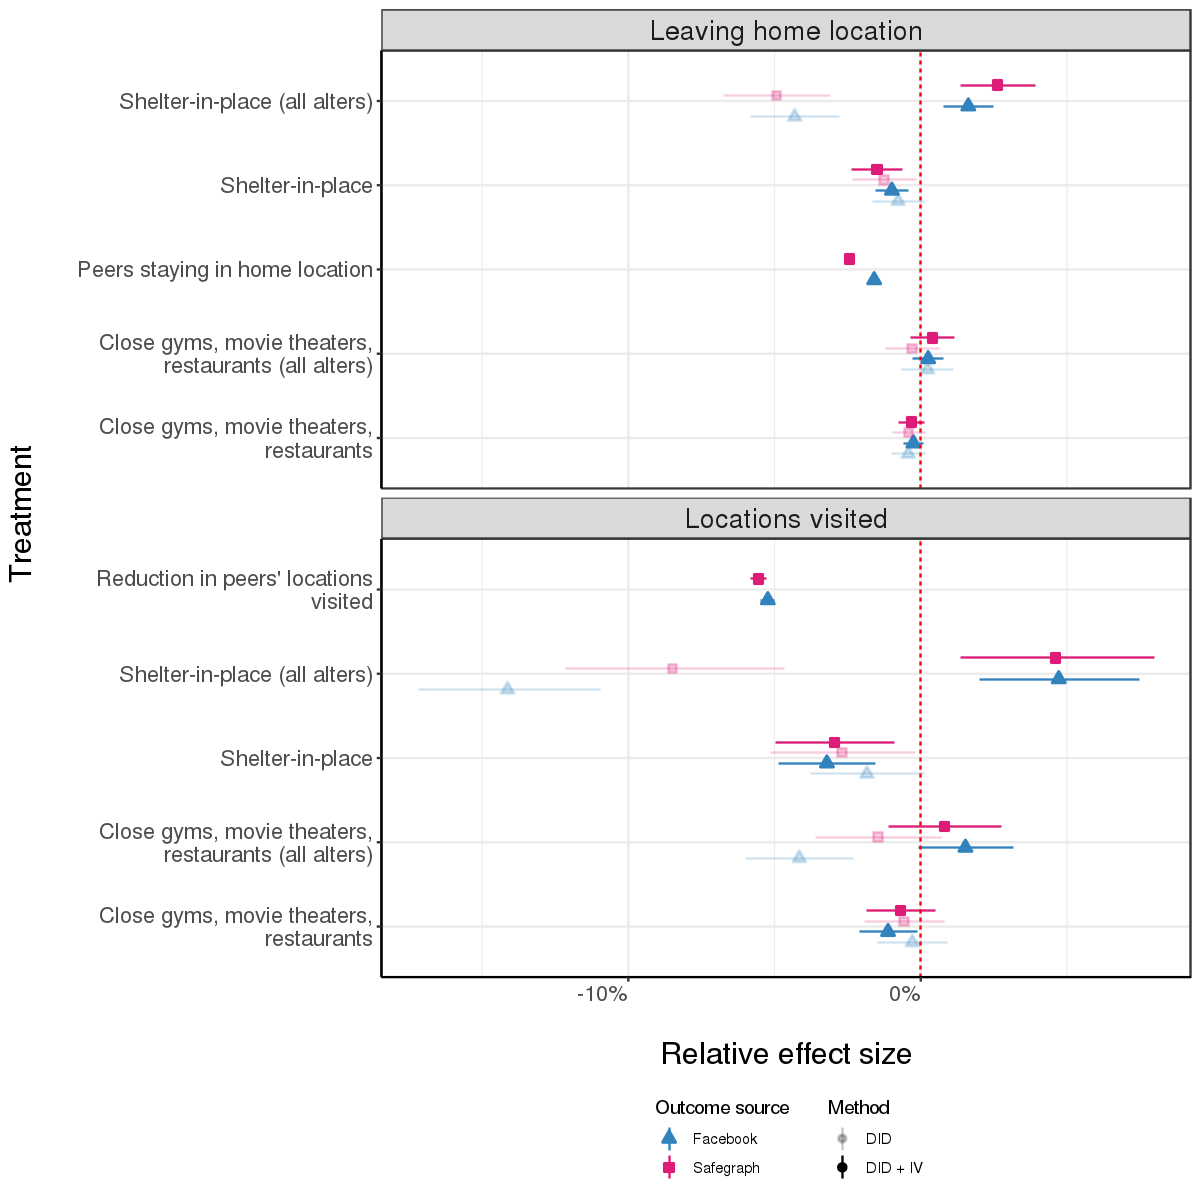

In [17]:
iv_plot <- iv_did_results_to_plot_trans %>%
    ungroup() %>%
    filter(!is.na(term_label)) %>%
    mutate(
        term_label = factor(str_wrap(term_label, 30)),
        term_label = reorder(term_label, grepl("peer", term_label))
    ) %>%
ggplot(aes(
      x = term_label,
      y=coef, ymin=lb, ymax=ub,
      color = outcome_source,
      #shape = paste(outcome_source, method),
      shape = outcome_source,
      fill = outcome_source,
      alpha = method
  )) +
  geom_pointrange(position = position_dodge(width = .5)) + 
  coord_flip() +
  scale_color_manual(name = "Outcome source", values = outcome_source_colors) +
  scale_shape_manual(name = "Outcome source", values = outcome_source_shapes) +
  #scale_shape_manual(name = "Outcome source", values = tmp) +
  scale_fill_manual(name = "Outcome source", values = outcome_source_colors) +
  scale_alpha_manual(name = "Method", values = c(.22, 1)) +
  facet_wrap(outcome_type ~ ., scales='free_y', nrow= 2, drop = TRUE) +
  geom_hline(yintercept=0, color=zero_color, linetype='dashed') + 
  scale_y_continuous(labels=percent) +
  ylab('\nRelative effect size') +
  xlab('Treatment\n') +
  theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        #strip.text.x = element_blank(),
        #strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.placement.x='top',
        #strip.background=element_blank(),
        strip.text.x.top = element_text(size=16),
        legend.position="bottom",
        #legend.position=c(.19, .9),
        legend.box = "horizontal"
) +
guides(
    fill = NULL,
    color = guide_legend(nrow = 2, title.position = "top", override.aes=list(shape = c(24, 22))),
    alpha = guide_legend(
        nrow = 2,
        override.aes=list(shape = c(20, 20)), title.position = "top"
    )
)
iv_plot

In [18]:
# Write plot to output
ggsave(
  paste0("../output/figures/iv_plot_with_did.pdf"),
  plot = iv_plot,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5.5,
  height = 7,
  limitsize = FALSE,
  useDingbats=FALSE
)

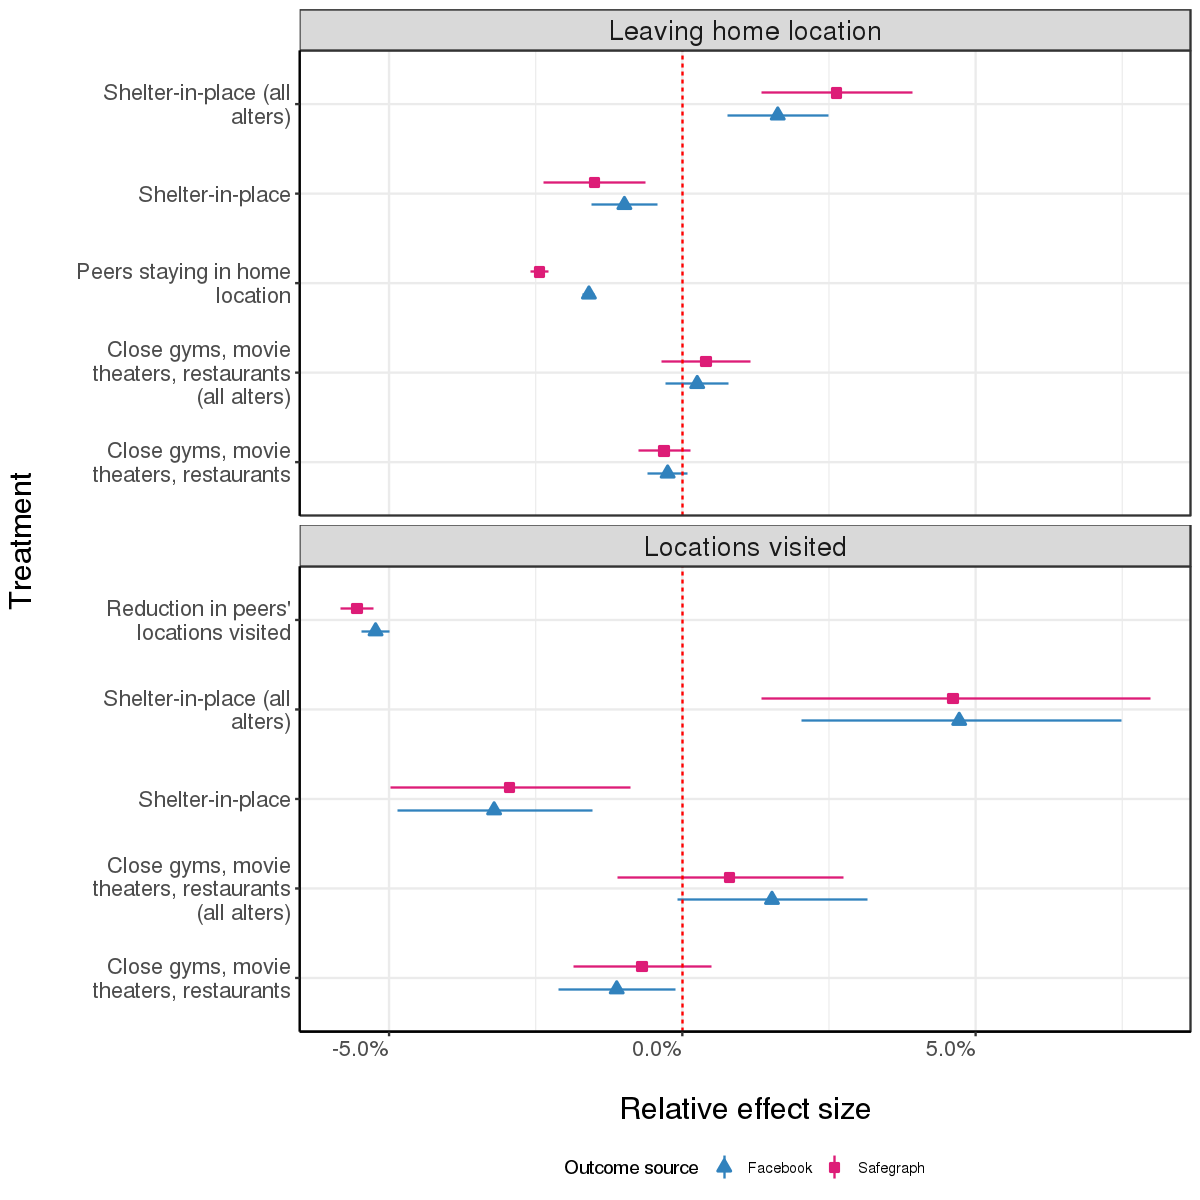

In [19]:
## no DID

iv_plot_no_did <- iv_did_results_to_plot_trans %>%
    ungroup() %>%
    filter(!is.na(term_label), method == "DID + IV") %>%
    mutate(
        term_label = factor(str_wrap(term_label, 25)),
        term_label = reorder(term_label, grepl("peer", term_label))
    ) %>%
ggplot(aes(
      x = term_label,
      y=coef, ymin=lb, ymax=ub,
      color = outcome_source,
      shape = outcome_source,
      fill = outcome_source
  )) +
  geom_pointrange(position = position_dodge(width = .5)) + 
  coord_flip() +
  scale_color_manual(name = "Outcome source", values = outcome_source_colors) +
  scale_shape_manual(name = "Outcome source", values = outcome_source_shapes) +
  scale_fill_manual(name = "Outcome source", values = outcome_source_colors) +
  facet_wrap(outcome_type ~ ., scales='free_y', nrow= 2, drop = TRUE) +
  geom_hline(yintercept=0, color=zero_color, linetype='dashed') + 
  scale_y_continuous(labels=percent) +
  ylab('\nRelative effect size') +
  xlab('Treatment\n') +
  theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        #strip.text.x = element_blank(),
        #strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.placement.x='top',
        #strip.background=element_blank(),
        strip.text.x.top = element_text(size=16),
        legend.position="bottom",
        #legend.position=c(.19, .9),
        legend.box = "horizontal"
) +
guides(
    fill = NULL,
    color = guide_legend(nrow = 1, title.position = "left", override.aes=list(shape = c(24, 22)))
)
iv_plot_no_did

In [20]:
ggsave(
  paste0("../output/figures/iv_plot_no_did.pdf"),
  plot = iv_plot_no_did,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5,
  height = 6.6,
  limitsize = FALSE,
  useDingbats=FALSE
)

In [26]:
iv_did_results_to_plot_trans %>%
    ungroup() %>%
    filter(
        method == "DID + IV",
        term_label %in% c('Alters staying in home location',
                          "Reduction in alters' locations visited",
                         "Shelter-in-place")
    ) %>%
    mutate(
        term_label = factor(str_wrap(term_label, 20)),
        term_label = reorder(term_label, grepl("peer", term_label))
    )

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label,method,logged
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<lgl>
stay_home.r,-0.03209,0.00873,-3.74,0.00048,fb_btvrc.r,-0.01539,-0.0485,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place,DID + IV,TRUE
stay_home.r,-0.00988,0.00291,-3.41,0.00130,ash_rnstu.r,-0.00421,-0.0155,Multi-tile users (FB),Leaving home location,Facebook,Shelter-in-place,DID + IV,TRUE
stay_home.r,-0.01499,0.00448,-3.37,0.00145,ash_nhd.r,-0.00630,-0.0236,Non-home-device fraction (Safegraph),Leaving home location,Safegraph,Shelter-in-place,DID + IV,TRUE
stay_home.r,-0.02950,0.01076,-2.78,0.00756,log_mcbgv.r,-0.00882,-0.0497,Census block group visits per device (Safegraph),Locations visited,Safegraph,Shelter-in-place,DID + IV,TRUE


In [28]:
print(unique(iv_did_results_to_plot_trans$term_label))

[1] "Close gyms, movie theaters, restaurants"             
[2] "Shelter-in-place"                                    
[3] "Reduction in peers' locations visited"               
[4] "Shelter-in-place (all alters)"                       
[5] "Close gyms, movie theaters, restaurants (all alters)"
[6] "Peers staying in home location"                      


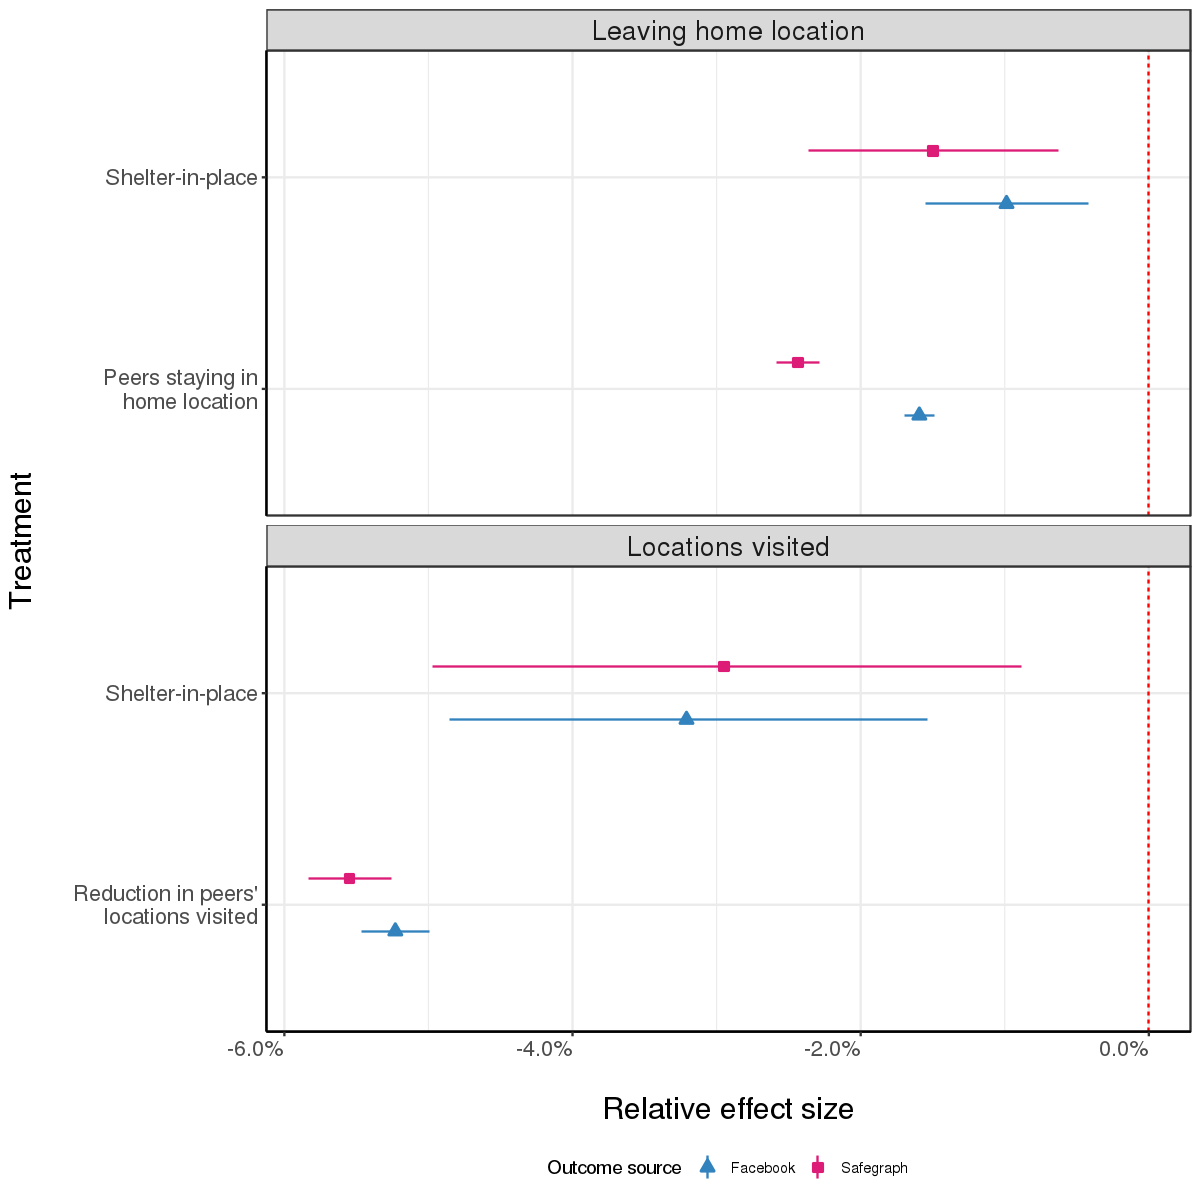

In [32]:
## no DID

iv_plot_simple <- iv_did_results_to_plot_trans %>%
    ungroup() %>%
    filter(
        method == "DID + IV",
        term_label %in% c('Peers staying in home location',
                          "Reduction in peers' locations visited",
                         "Shelter-in-place")
    ) %>%
    mutate(
        term_label = factor(str_wrap(term_label, 20))
    ) %>%
ggplot(aes(
      x = term_label,
      y=coef, ymin=lb, ymax=ub,
      color = outcome_source,
      shape = outcome_source,
      fill = outcome_source
  )) +
  geom_pointrange(position = position_dodge(width = .5)) + 
  coord_flip() +
  scale_color_manual(name = "Outcome source", values = outcome_source_colors) +
  scale_shape_manual(name = "Outcome source", values = outcome_source_shapes) +
  scale_fill_manual(name = "Outcome source", values = outcome_source_colors) +
  facet_wrap(outcome_type ~ ., scales='free_y', nrow= 2, drop = TRUE) +
  geom_hline(yintercept=0, color=zero_color, linetype='dashed') + 
  scale_y_continuous(labels=percent) +
  ylab('\nRelative effect size') +
  xlab('Treatment\n') +
  theme(axis.text.x = element_text(hjust = 1, size=13),
        axis.text.y = element_text(size=13),
        axis.title = element_text(size=18),
        #strip.text.x = element_blank(),
        #strip.text.y = element_text(size=16),
        panel.background = element_blank(),
        axis.line = element_line(colour = "black"),
        strip.placement.x='top',
        #strip.background=element_blank(),
        strip.text.x.top = element_text(size=16),
        legend.position="bottom",
        #legend.position=c(.19, .9),
        legend.box = "horizontal"
) +
guides(
    fill = NULL,
    color = guide_legend(nrow = 1, title.position = "left", override.aes=list(shape = c(24, 22)))
)
iv_plot_simple

In [33]:
ggsave(
  paste0("../output/figures/iv_plot_simple.pdf"),
  plot = iv_plot_simple,
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 5,
  height = 4,
  limitsize = FALSE,
  useDingbats=FALSE
)

## IV tables

In [23]:
iv_results

term,coef,se,statistic,p.value,lhs,ub,lb,outcome,outcome_type,outcome_source,term_label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ban_gmr.r,-0.011251,0.00513,-2.1933,3.30e-02,fb_btvrc.r,-0.001197,-0.021305,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants"
alter_bgmr.r,0.004023,0.01205,0.3337,7.40e-01,fb_btvrc.r,0.027649,-0.019604,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (social alters)"
geo_alter_bgmr.r,0.011144,0.00859,1.2973,2.00e-01,fb_btvrc.r,0.027982,-0.005693,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (geo alters)"
stay_home.r,-0.032617,0.00873,-3.7365,4.80e-04,fb_btvrc.r,-0.015508,-0.049726,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place
alter_sh.r,0.050630,0.01944,2.6050,1.21e-02,fb_btvrc.r,0.088724,0.012536,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (social alters)
geo_alter_sh.r,-0.004510,0.01011,-0.4462,6.57e-01,fb_btvrc.r,0.015298,-0.024317,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (geo alters)
`fb_alter_btvrc.r(fit)`,1.646931,0.03908,42.1460,9.80e-41,fb_btvrc.r,1.723521,1.570340,Tiles visited per device (FB),Locations visited,Facebook,Tiles per peer device (FB)
comb_alter_sh.r,0.046121,0.01330,NA,5.23e-04,fb_btvrc.r,0.072179,0.020062,Tiles visited per device (FB),Locations visited,Facebook,Shelter-in-place (all alters)
comb_alter_bgmr.r,0.015167,0.00813,NA,6.19e-02,fb_btvrc.r,0.031092,-0.000758,Tiles visited per device (FB),Locations visited,Facebook,"Close gyms, movie theaters, restaurants (all alters)"


In [24]:
star <- stargazer(
    iv_models,
    covariate.labels = na.omit(unique(unlist(lapply(iv_cts, function(x) (table_term_labels[tidy(x)$term]))))),
    dep.var.labels = outcome_table_labels[sapply(iv_models, function(m) m$lhs)],
    coef = lapply(iv_cts, function(x) (tidy(x))$estimate),
    se = lapply(iv_cts, function(x) (tidy(x))$std.error),
    omit = "shift",
    #omit.labels = "shift",
    add.lines = list(
      c('Conley s.e.', 'Yes', 'Yes', 'Yes', 'Yes'),
      c('County fixed effect', 'Yes', 'Yes', 'Yes', 'Yes'),
      c('Day fixed effect', 'Yes', 'Yes', 'Yes', 'Yes')),
    label='tab:iv',
    title='Effects of policy interventions and endogenous alter behaviors (Full set of instruments)',
    notes.append=FALSE,
    notes.align='l',
    font.size='footnotesize',
    digits=3
    )

note.latex <- "\\multicolumn{5}{l} {\\parbox[t]{\\textwidth}{ \\textit{Notes:} NSBTU refers to the fraction of FB users in a given county who visit multiple Bing tiles on a given day. NHDF refers to the fraction of devices that are not completely at home, as measured by Safegraph. dCBGVs refers to the mean number of census block groups devices from a given county visit, as measured by Safegraph. BTVRC refers to the relative change in the number of Bing tiles users visit, as measured by FB. $^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01}} \\\\"
star[grepl("Note",star)] <- note.latex
cat(star, sep = "\n", file = '../output/iv_main.tex')


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Fri, May 08, 2020 - 03:39:30 PM
\begin{table}[!htbp] \centering 
  \caption{Effects of policy interventions and endogenous alter behaviors (Full set of instruments)} 
  \label{tab:iv} 
\footnotesize 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & BTVRC & asinh(NSBTUs) & asinh(NHDF) & log(dCBGVs) \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 Close gyms, movie theaters, restaurants & $-$0.011$^{**}$ & $-$0.003 & $-$0.003 & $-$0.007 \\ 
  & (0.005) & (0.002) & (0.002) & (0.006) \\ 
  & & & & \\ 
 Close gyms, movie theaters, restaurants (social alters) & 0.004 & $-$0.001 & 0.007 & 0.002 \\ 
  & (0.012) & (0.005) & (0.007) & (0.020) \\ 
  & & & & \\ 
 Close gyms, movie theaters, restaurants (geo alters) & 0.011 & 0.003 & $-$0.003 & 0.006